In [1]:

#This is Machine Learning
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
import pathlib
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
import keras.utils as image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import seaborn as sns


import glob
import os
from os import listdir
import requests
from zipfile import ZipFile

import random

random.seed(0)
import cv2
from matplotlib.image import imread

from IPython.display import display, Image

2023-12-05 17:16:33.398911: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data Importing

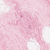

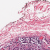

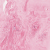

In [2]:
#Got this from ChatGPT

# Define the GitHub repository URL
repo_url = 'https://github.com/StevenHPatrick/breastCancerData/archive/94de9300f0851b14430654cd36089af864e6017b.zip'

# Specify the local path to save the downloaded file
zip_file_path = 'breast_cancer_data.zip'

# Specify the target directory
output_dir = 'breast_cancer_data'

# Check if the target directory already exists
if not os.path.exists(output_dir):
    # Download the dataset from GitHub
    response = requests.get(repo_url)
    with open(zip_file_path, 'wb') as zip_file:
        zip_file.write(response.content)

    # Extract the contents of the ZIP file
    extracted_path = 'breastCancerData-94de9300f0851b14430654cd36089af864e6017b'
    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

    # Adjust the path to include the additional subdirectory
    dataset_path = os.path.join(extracted_path, 'breastCancerData-94de9300f0851b14430654cd36089af864e6017b')

    # Create the 'breast_cancer_data' directory
    os.makedirs(output_dir)

    # Move the contents to 'breast_cancer_data' directory
    for item in os.listdir(dataset_path):
        s = os.path.join(dataset_path, item)
        d = os.path.join(output_dir, item)
        os.rename(s, d)

# Now, breast_img will contain the paths to the images in 'breast_cancer_data'
breast_img = glob.glob(os.path.join(output_dir, 'archive/IDC_regular_ps50_idx5/**/*.png'), recursive=True)

# Display the first 3 images
for img_path in breast_img[:3]:
    display(Image(filename=img_path))


In [3]:
non_img = []
can_img = []

for img in breast_img:
    if img[-5] == '0' :
        non_img.append(img)

    elif img[-5] == '1' :
        can_img.append(img)
breast_img[0]

'breast_cancer_data/archive/IDC_regular_ps50_idx5/9254/0/9254_idx5_x901_y701_class0.png'

Data Discovery

In [4]:
patients = [len(non_img), len(can_img)]

total_img_num = patients[0] + patients[1]

print('Number of benign patients' .format(patients[0]))
print('Number of malignant patients' .format(patients[1]))
print('Total Number of Images : {}' .format(total_img_num))

Number of benign patients
Number of malignant patients
Total Number of Images : 277524


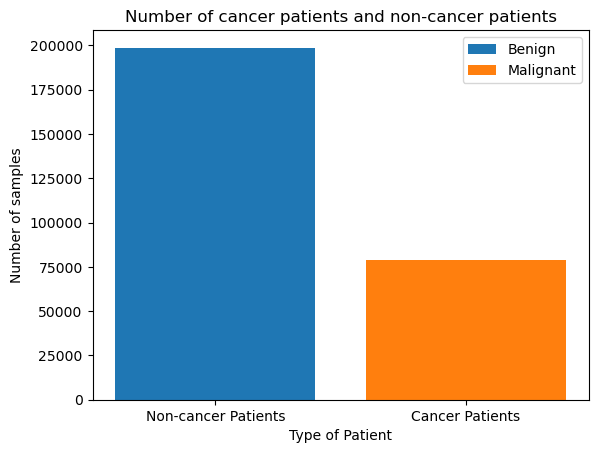

In [5]:
#Written by Steven and only Steven
plt.bar("Non-cancer Patients", patients[0], label = 'Benign')
plt.bar("Cancer Patients", patients[1], label = 'Malignant')
plt.ylabel("Number of samples")
plt.xlabel("Type of Patient")
plt.title("Number of cancer patients and non-cancer patients")
plt.legend()
plt.show();

277534 images is a lot to train on. We decided to reduce the number of images we are training on.

In [6]:
non_img = np.array(non_img)
can_img = np.array(can_img)

# Generate random indices
fivek_no_cancer_indices = np.random.randint(0, len(non_img), 5000)
fivek_cancer_indices = np.random.randint(0, len(can_img), 5000)

# Use boolean indexing to copy the selected images
fivek_no_cancer = non_img[fivek_no_cancer_indices]
fivek_cancer = can_img[fivek_cancer_indices]

In [7]:
patients = [len(fivek_no_cancer), len(fivek_cancer)]

total_img_num = patients[0] + patients[1]

print('Number of benign patients' .format(patients[0]))
print('Number of malignant patients' .format(patients[1]))
print('Total Number of Images : {}' .format(total_img_num))

Number of benign patients
Number of malignant patients
Total Number of Images : 10000


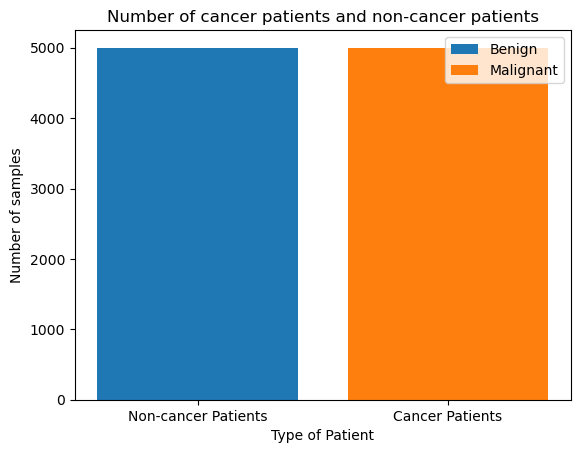

In [8]:
#Written by Steven and only Steven
plt.bar("Non-cancer Patients", patients[0], label = 'Benign')
plt.bar("Cancer Patients", patients[1], label = 'Malignant')
plt.ylabel("Number of samples")
plt.xlabel("Type of Patient")
plt.title("Number of cancer patients and non-cancer patients")
plt.legend()
plt.show();

This is a more managable size to start training on. We will look at increasing the dataset later one.

In [9]:
total_img_num = len(fivek_no_cancer) + len(fivek_cancer)

print('Number of Images of no cancer: {}' .format(len(fivek_no_cancer)))   # images of Non cancer
print('Number of Images of cancer : {}' .format(len(fivek_cancer)))   # images of cancer
print('Total Number of Images : {}' .format(total_img_num))

Number of Images of no cancer: 5000
Number of Images of cancer : 5000
Total Number of Images : 10000


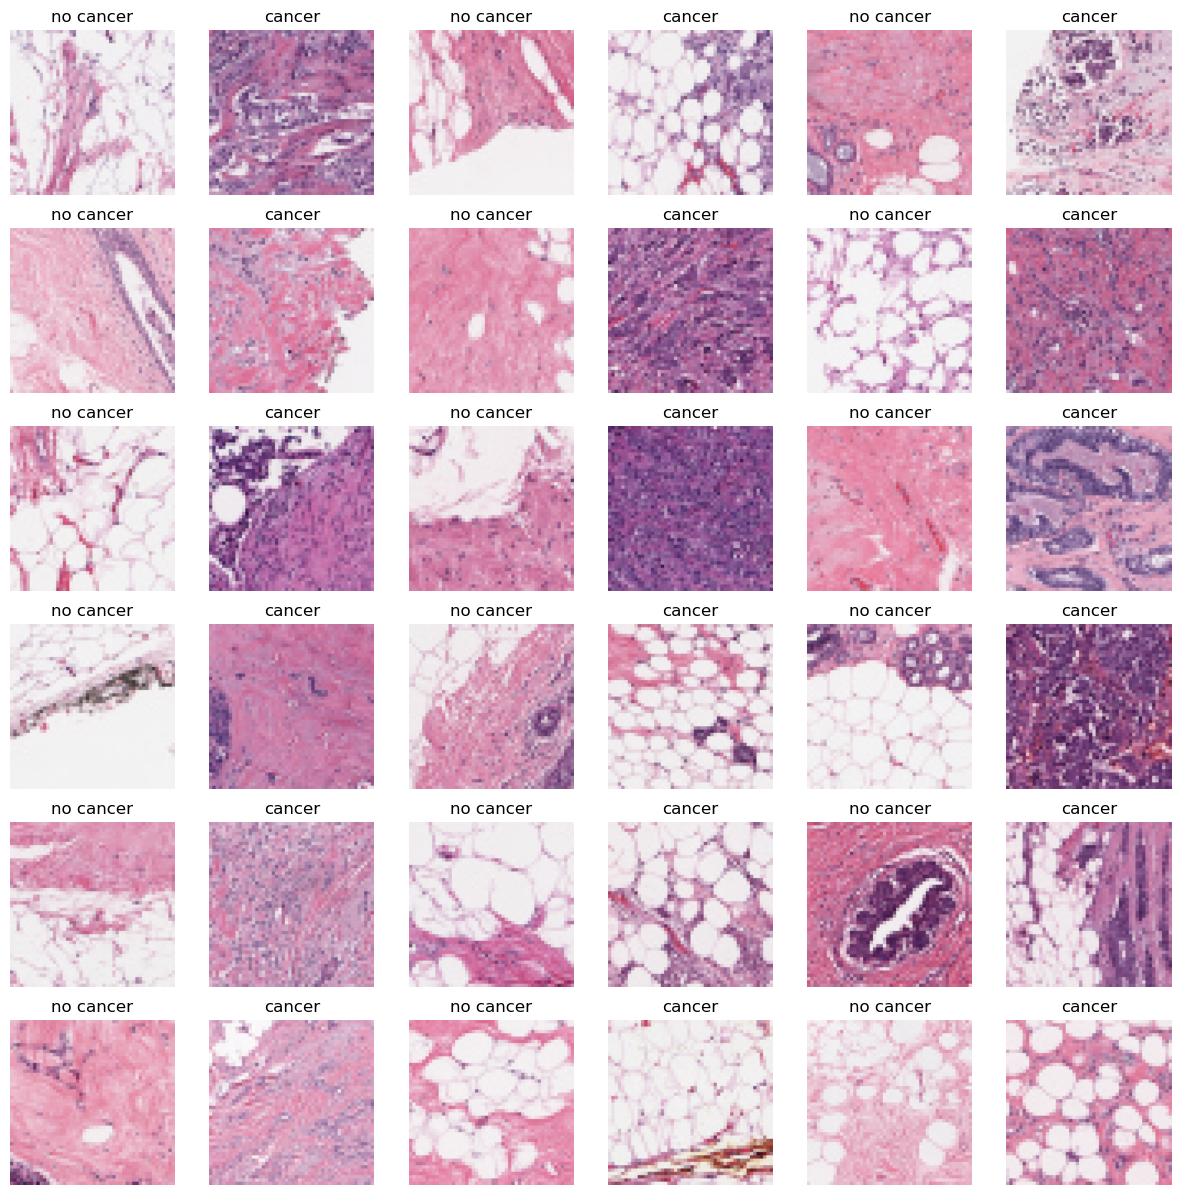

In [10]:
#Took this code from a kaggle notebook because it looked too cool. Also, it confirms that 

plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(fivek_no_cancer), 18)
some_can = np.random.randint(0, len(fivek_cancer), 18)

s = 0
for num in some_non:
    
        img = image.load_img((fivek_no_cancer[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1

s = 1
for num in some_can:
    
        img = image.load_img((fivek_cancer[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
plt.show()


Data Preprocessing

In [11]:
# Randomly sample images from two lists, 'non_cancer_imgs' and 'cancer_imgs'
some_non_img = random.sample(non_img, len(non_img))
some_can_img = random.sample(can_img, len(can_img))

# Initialize empty arrays to store image data and labels
non_img_arr = []  # Array for non-cancer images
can_img_arr = []  # Array for cancer images

# Loop through each image in the 'some_non_img' list
for img in some_non_img:
    # Read the image in color mode
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    # Resize the image to a fixed size (50x50 pixels) using linear interpolation
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    # Append the resized image and label 0 (indicating non-cancer) to the 'non_img_arr'
    non_img_arr.append([n_img_size, 0])

    # Loop through each image in the 'some_can_img' list
for img in some_can_img:
    # Read the image in color mode
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    # Resize the image to a fixed size (50x50 pixels) using linear interpolation
    c_img_size = cv2.resize(c_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    # Append the resized image and label 1 (indicating cancer) to the 'can_img_arr'
    can_img_arr.append([c_img_size, 1])

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).